In [1]:
# For data
import pandas as pd
import numpy as np

import os

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.lines as mlines
import matplotlib.colors as mcolors


# For data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Filter methods
# spearman 
# chi-square
import scipy.stats as stats
from scipy.stats import chi2_contingency

# Wrapper methods - Recursive Feature Elimination (RFE)
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.feature_selection import RFE
from tqdm import tqdm                         # For progress bar

# Embedded methods
from sklearn.feature_selection import SelectFromModel
from sklearn import linear_model

# Set the style of the visualization
pd.set_option('display.max_columns', None) # display all columns

# Disable FutureWarnings
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

# for better resolution plots
%config InlineBackend.figure_format = 'retina' # optionally, you can change 'svg' to 'retina'

# Setting seaborn style
sns.set_theme(style="white")

In [2]:
# Load the training and validation sets after feature engineering
X_train = pd.read_parquet('data/2ndNotebook/X_train.parquet')
X_val = pd.read_parquet('data/2ndNotebook/X_val.parquet')
test_data = pd.read_parquet('data/2ndNotebook/test_data.parquet')

# Load the target variable
y_train = pd.read_parquet('data/2ndNotebook/y_train.parquet').squeeze()   # .squeeze() to convert to Series
y_val = pd.read_parquet('data/2ndNotebook/y_val.parquet').squeeze()


# Check the shape of the training, validation and test data

# Check the shape of the training, validation and test data (Features)
print(X_train.shape, X_val.shape, test_data.shape)

# Check the shape of the training, validation and test data (Target)
print('\n',y_train.shape, y_val.shape)

(430519, 67) (143507, 67) (387975, 67)

 (430519,) (143507,)


In [3]:
# Associate the data types ['int64' - Numerical and 'int32' - Binary -  Just to be more easy to identify the binary columns]
# Define binary and numerical columns
binary_columns = [
    'Accident Date Binary', 'C-2 Date Binary', 'C-3 Date Binary', 'First Hearing Date Binary', 
    'COVID-19 Indicator_Y', 'Alternative Dispute Resolution_U', 'Alternative Dispute Resolution_Y', 
    'Carrier Type Bucket_1A. PRIVATE', 'Carrier Type Bucket_2A. SIF', 'Carrier Type Bucket_3A. SELF PUBLIC',
    'Carrier Type Bucket_4A. SELF PRIVATE', 'Carrier Type Bucket_5A-5C. SPECIAL FUND',
    'Medical Fee Region_II',
    'Medical Fee Region_III',
    'Medical Fee Region_IV',
    'Medical Fee Region_UK',
    'WCIO Cause of Injury Bucket_1 - Temp',
    'WCIO Cause of Injury Bucket_10 - Miscellaneous',
    'WCIO Cause of Injury Bucket_2 - Caught',
    'WCIO Cause of Injury Bucket_3 - Cut',
    'WCIO Cause of Injury Bucket_4 - Fall',
    'WCIO Cause of Injury Bucket_5 - Motor Vehicle',
    'WCIO Cause of Injury Bucket_6 - Strain_data',
    'WCIO Cause of Injury Bucket_7 - Striking',
    'WCIO Cause of Injury Bucket_8 - Struck',
    'WCIO Cause of Injury Bucket_9 - Rubbed',
    'WCIO Nature of Injury Bucket_1 - Specific',
    'WCIO Nature of Injury Bucket_2 - Occupational/Cumulative',
    'WCIO Nature of Injury Bucket_3 - Multiple',
    'WCIO Part of Body Bucket_I - Head',
    'WCIO Part of Body Bucket_II - Neck',
    'WCIO Part of Body Bucket_III - Upper Extremities',
    'WCIO Part of Body Bucket_IV - Trunk',
    'WCIO Part of Body Bucket_V - Lower Extremities',
    'WCIO Part of Body Bucket_VI - Multiple Body Parts',
    'Attorney/Representative_Y', 'Gender_M', 'Gender_U', 'Gender_X', 'District Name_BINGHAMTON', 
    'District Name_BUFFALO', 'District Name_HAUPPAUGE', 'District Name_NYC', 
    'District Name_ROCHESTER', 'District Name_STATEWIDE', 'District Name_SYRACUSE', 
    'IME-4 Reported', 'Weekly Wage Reported'
]

numerical_columns = [
    'Accident Date Day', 'Accident Date Month', 'Accident Date Weekday', 'Accident Date Year', 
    'Assembly Date Day', 'Assembly Date Month', 'Assembly Date Weekday', 'Assembly Date Year', 
    'C-2 Date Day', 'C-2 Date Month', 'C-2 Date Weekday', 'C-2 Date Year', 
    'Age at Injury Clean', 'Industry Code', 'Number of Dependents', 
    'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code',
]

# Update the data types for the columns (binary columns as 'int32', numerical columns as 'int64')
X_train[binary_columns] = X_train[binary_columns].astype('int32')
X_val[binary_columns] = X_val[binary_columns].astype('int32')
test_data[binary_columns] = test_data[binary_columns].astype('int32')

X_train['Age at Injury Group'] = X_train['Age at Injury Group'].astype('int32')
X_val['Age at Injury Group'] = X_val['Age at Injury Group'].astype('int32')
test_data['Age at Injury Group'] = test_data['Age at Injury Group'].astype('int32')

X_train[numerical_columns] = X_train[numerical_columns].astype('int64')
X_val[numerical_columns] = X_val[numerical_columns].astype('int64')
test_data[numerical_columns] = test_data[numerical_columns].astype('int64')

# RFE (Logistic MinMax)

In [5]:
minmax_scaler = MinMaxScaler().fit(X_train[numerical_columns + ['Age at Injury Group']])

In [6]:
X_train_norm = X_train.copy()
X_val_norm = X_val.copy()
test_data_norm = test_data.copy()

X_train_norm[numerical_columns + ['Age at Injury Group']] = minmax_scaler.transform(X_train[numerical_columns + ['Age at Injury Group']])
X_val_norm[numerical_columns + ['Age at Injury Group']] = minmax_scaler.transform(X_val[numerical_columns + ['Age at Injury Group']])
test_data_norm[numerical_columns + ['Age at Injury Group']] = minmax_scaler.transform(test_data[numerical_columns + ['Age at Injury Group']])


In [7]:
# -------------------------------------- [RFE] --------------------------------------
# No of features
nof_list = np.arange(1, len(X_train_norm.columns) + 1)    # No of features (all aranged from 1 to n_features)          
                                                                      #### Change to enc_norm or enc_log 

high_score = 0                                                        # Variable to store the highest score 

# Variable to store the optimum features
nof = 0
train_score_list = []
val_score_list = []

# Loop to select the best no of features [RFE]
for n in tqdm(range(len(nof_list))):

    model = LogisticRegression(max_iter=100,      
                                solver='lbfgs',        
                                random_state=2024)     
    # RFE 
    rfe = RFE(estimator = model, n_features_to_select = nof_list[n])

    # Fit the model
    X_train_rfe = rfe.fit_transform(X_train_norm, y_train) 
    X_val_rfe = rfe.transform(X_val_norm)                 
    model.fit(X_train_rfe,y_train)
    
    # Storing results on training data - We will choose the best score based on F1-Score       
    pred_train = model.predict(X_train_rfe)
    train_score = metrics.f1_score(y_train, pred_train, average='macro')
    train_score_list.append(train_score)
    
    # Storing results on training data
    pred_val = model.predict(X_val_rfe)
    val_score = metrics.f1_score(y_val, pred_val, average='macro')
    val_score_list.append(val_score)
    
    # Check best score
    if (val_score >= high_score):
        high_score = val_score
        nof = nof_list[n]

        # Features to select (adding mention of variables to keep)
        features_to_select = pd.Series(rfe.support_, index = X_train_norm.columns)    

## Time of Execution RFE: 17h 51min 09s [23.11.2024 - Logistic Regression with MinMaxScaler]

100%|██████████| 67/67 [17:51:09<00:00, 959.25s/it]    


In [23]:
# Save the results of the RFE - Excel file with Model's name
results_rfe.to_excel('RFE_Results_LogisticRegression_MiniMaxScaler_23.11.2024.xlsx')     ### Change file name

In [8]:
# Print the optimum number of features and the score with that number of features
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))
print("\nFeatures to select:")

# Show the features to select
results_rfe = features_to_select.to_frame()
results_rfe.index.name = 'Feature'
results_rfe.columns = ['Selected']
results_rfe.sort_index(inplace=True)
results_rfe

Optimum number of features: 58
Score with 58 features: 0.381752

Features to select:


,Selected
Feature,
Accident Date Binary,True
Accident Date Day,True
Accident Date Month,True
Accident Date Weekday,False
Accident Date Year,True
...,...
WCIO Part of Body Bucket_III - Upper Extremities,True
WCIO Part of Body Bucket_IV - Trunk,True
WCIO Part of Body Bucket_V - Lower Extremities,True


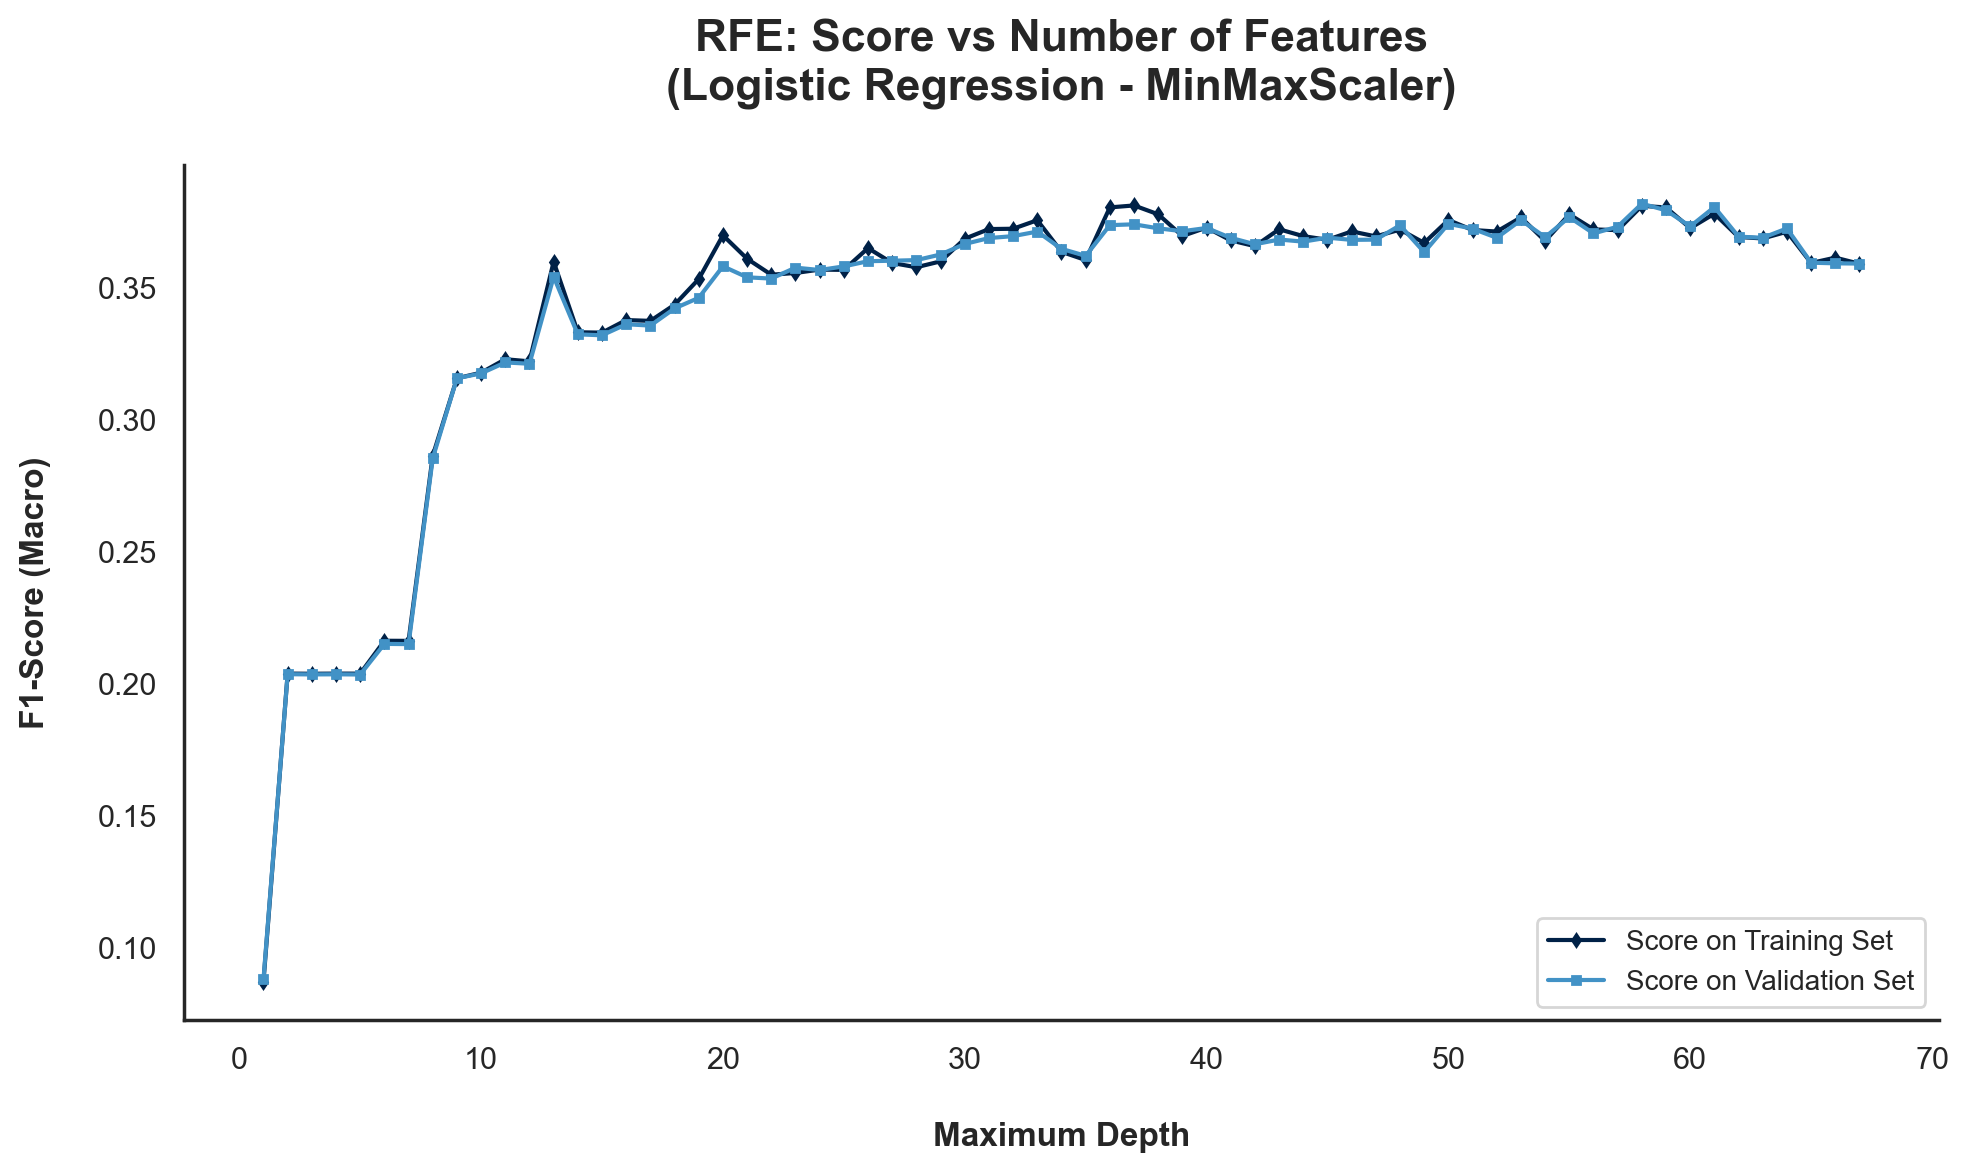

In [29]:
# Plot the results of the RFE
fig = plt.figure(figsize=(10,6))
plt.plot(list(range(1,len(X_train_norm.columns) + 1)), train_score_list, label="Score on Training Set", color='#002147', marker='d', markersize=3)
plt.plot(list(range(1,len(X_train_norm.columns) + 1)), val_score_list, label="Score on Validation Set", color='#4292C6', marker='s', markersize=3)

# Customizing the plot
plt.title("RFE: Score vs Number of Features\n(Logistic Regression - MinMaxScaler)\n", fontsize=16, fontweight='bold')
plt.xlabel("\nMaximum Depth", fontsize=12, fontweight='bold')
plt.ylabel("F1-Score (Macro)\n", fontsize=12, fontweight='bold')
plt.legend(loc='best', fontsize=10, frameon=True)

sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

# Ridge and Lasso

In [11]:
#################################################### Embedded Methods ####################################################
## 1. Lasso Regularization - compare simple logistic regressions
## 2. Ridge Regularization - compare simple logistic regressions

# Assign the features to the X and y variables for the Lasso and Ridge Regularization
X = X_train_norm.values
y = y_train.values

# Feature names
feature_names = X_train_norm.columns

# Lasso Regularization
lasso_selector = SelectFromModel(estimator= linear_model.LogisticRegression(C=1,                               # Regularization strength
                                                                            penalty="l1",                      # Lasso
                                                                            solver='saga'),                    # Algorithm to use in the optimization problem
                                                                                                               # Source: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
                                                                            max_features=len(feature_names),   # Maximum number of features to select
                                                                            threshold="1.25*mean").fit(X,y)    # Threshold for feature selection (need to transform the coef_ values)

lasso_selected_features = feature_names[lasso_selector.get_support()]

# Assign the features to the X and y variables for the Lasso Regularization
# Source: https://stackoverflow.com/questions/75027483/why-sklearn-selectfrommodel-estimator-coef-return-a-2d-array
#         https://stackoverflow.com/questions/64581307/how-to-properly-do-feature-selection-with-selectfrommodel-from-scikit-learn
lasso_coef = pd.Series(abs(lasso_selector.estimator_.coef_).mean(axis=0)*1.25, index=feature_names)
lasso_imp_coef = lasso_coef.sort_values(ascending=True)

# Ridge Regularization
ridge_selector = SelectFromModel(estimator= linear_model.LogisticRegression(C=1,                               # Regularization strength
                                                                            penalty="l2",                      # Ridge
                                                                            solver='sag',                      # Algorithm to use in the optimization problem
                                                                            max_iter=1000),                    # Ensure convergence
                                                                            max_features=len(feature_names),   # Maximum number of features to select
                                                                            threshold="1.25*mean").fit(X, y)   # Threshold (need to transform the coef_ values)

ridge_selected_features = feature_names[ridge_selector.get_support()]

# Assign the coefficients to the selected features for the Ridge Regularization
ridge_coef = pd.Series(abs(ridge_selector.estimator_.coef_).mean(axis=0)*1.25, index=feature_names)
ridge_import_coef = ridge_coef.sort_values(ascending=True)

## Time of Execution Ridge and Lasso Regularization = XXm XXs

In [25]:
lasso_ridge_coef.to_excel('Lasso_Ridge_Coefficients_LogisticRegression_MinMaxScaler_23.11.2024.xlsx')     ### Change file name

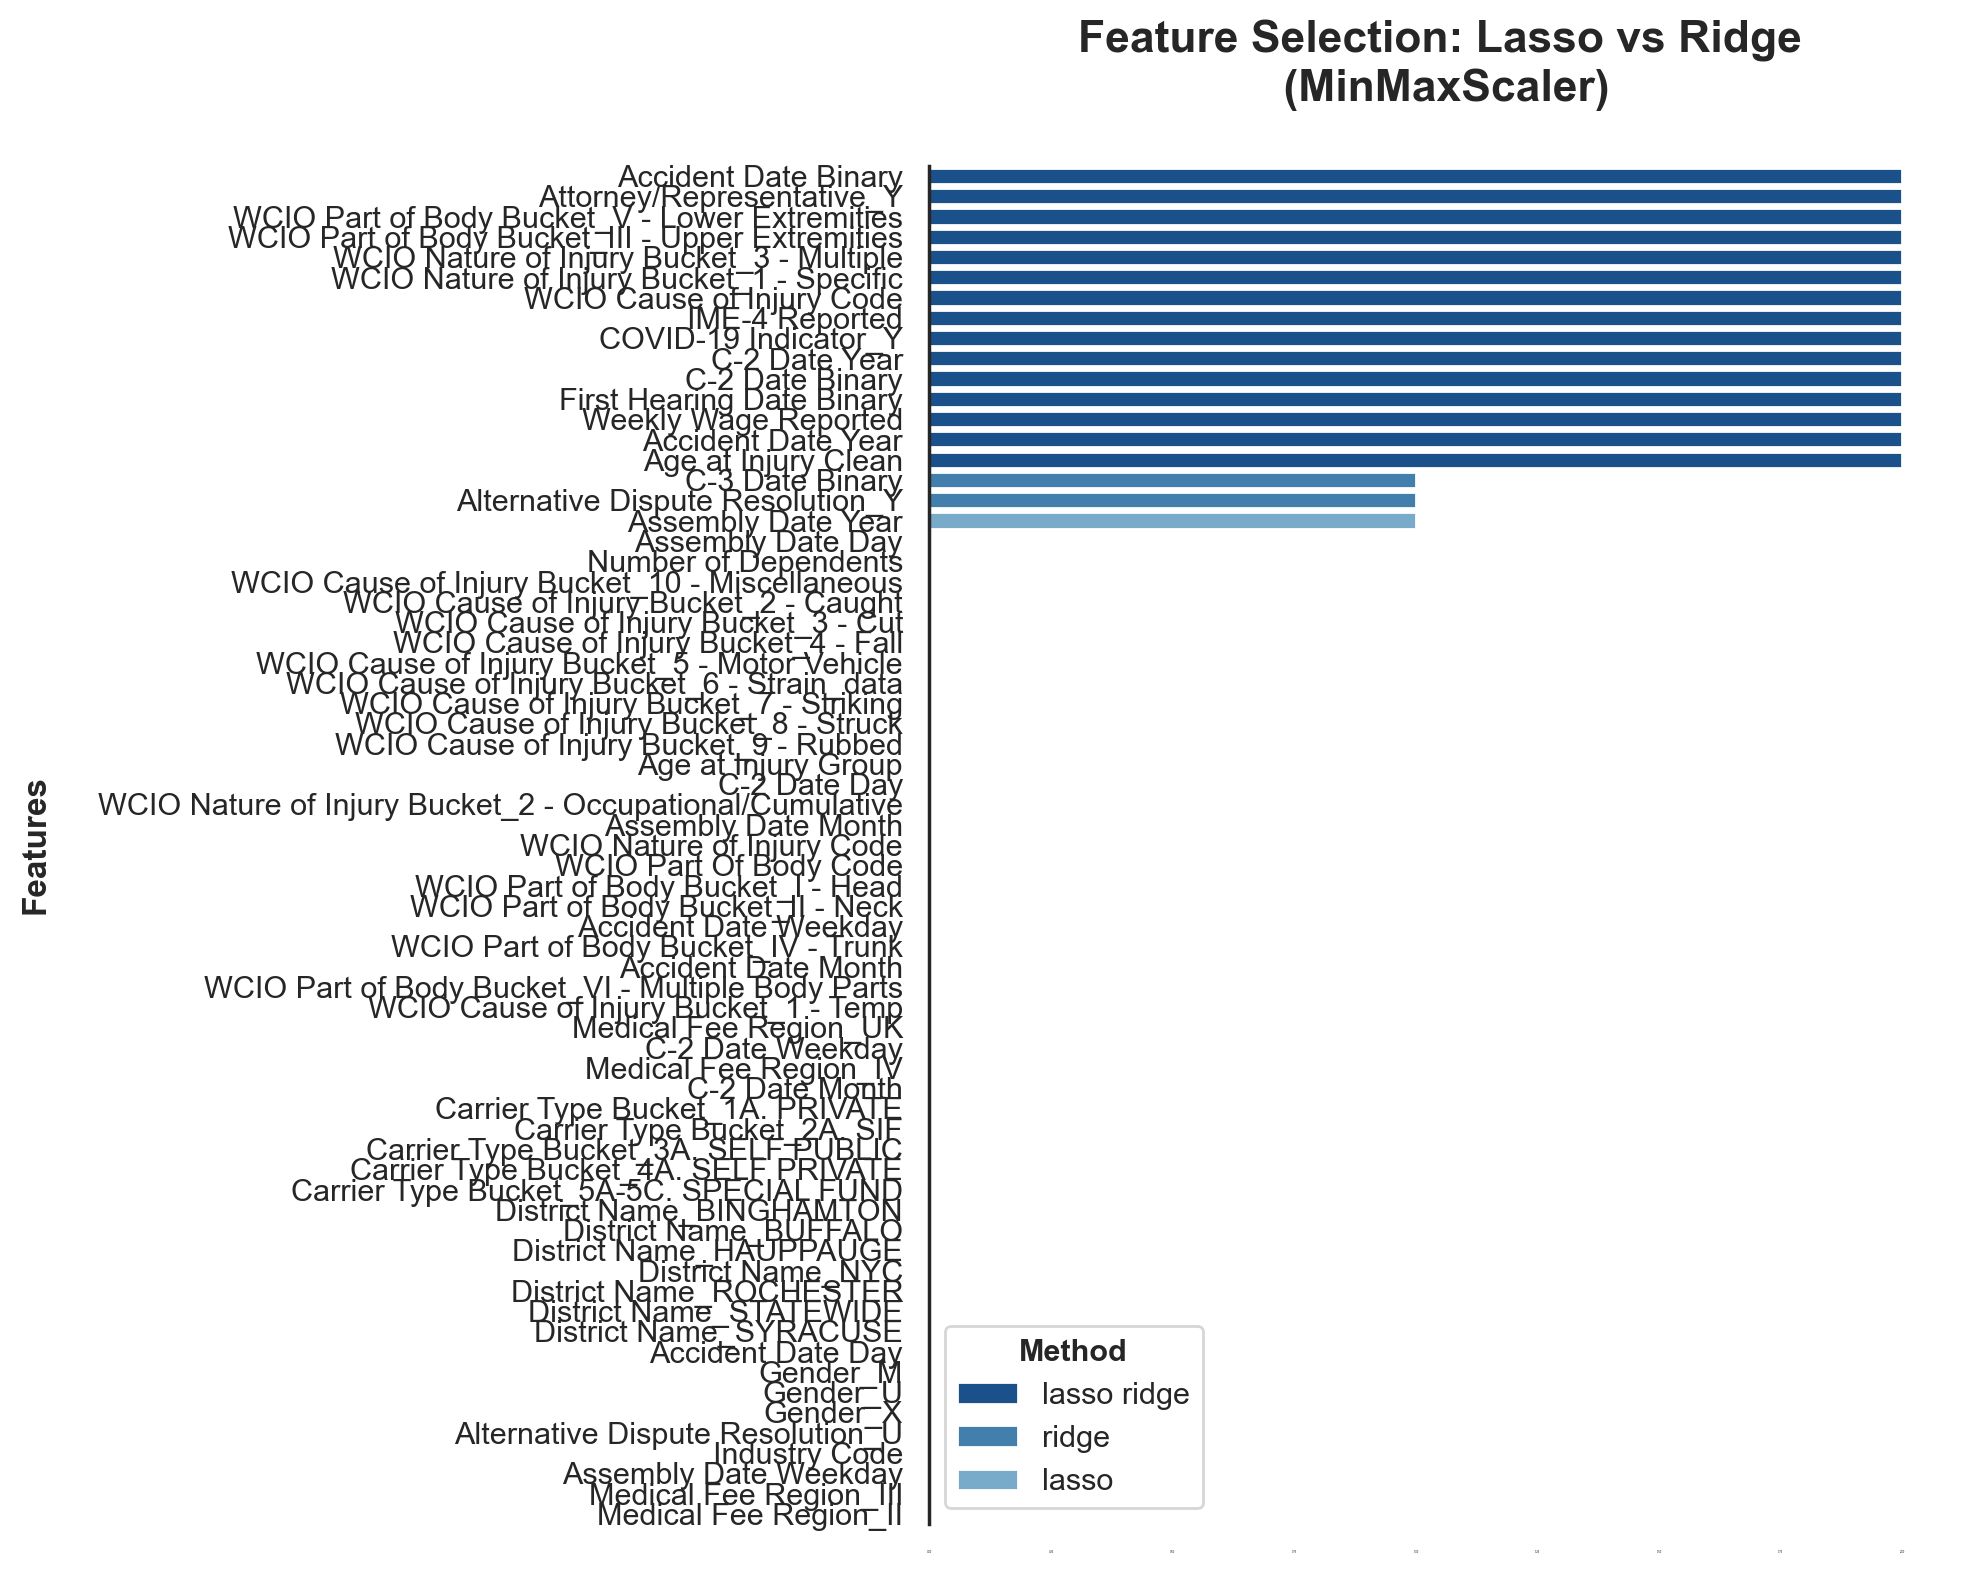

In [31]:

## Plot the results of the Lasso and Ridge Regularization
dtf_features = pd.DataFrame({"features": feature_names})
dtf_features["lasso"] = dtf_features["features"].apply(lambda x: "lasso" if x in lasso_selected_features else "")
dtf_features["num1"] = dtf_features["features"].apply(lambda x: 1 if x in lasso_selected_features else 0)

dtf_features["ridge"] = dtf_features["features"].apply(lambda x: "ridge" if x in ridge_selected_features else "")
dtf_features["num2"] = dtf_features["features"].apply(lambda x: 1 if x in ridge_selected_features else 0)

dtf_features["method"] = dtf_features[["lasso", "ridge"]].apply(lambda x: (x[0] + " " + x[1]).strip(), axis=1)
dtf_features["selection"] = dtf_features["num1"] + dtf_features["num2"]

# plot
plt.figure(figsize=(10, 8))
sns.barplot(y="features", x="selection", hue="method", 
            data=dtf_features.sort_values("selection", ascending=False), dodge=False,
            palette={"lasso": "#6BAED6", "ridge": "#3182BD", 'lasso ridge':'#08519C'})

plt.title('Feature Selection: Lasso vs Ridge\n (MinMaxScaler)\n', fontsize=16, fontweight='bold')
plt.ylabel('Features\n', fontsize=12, fontweight='bold')
plt.xlabel('')
plt.xticks(fontsize=0)
plt.legend(title="Method", fontsize='11', title_fontproperties={'weight':'bold', 'size':'11'})
sns.despine(top=True, right=True, bottom=True)
plt.tight_layout()
plt.show()

## Normal blue: Lasso
## light blue: Ridge
## Dark blue:  Both Lasso and Ridge

In [17]:
# Dataframe with the abs. coefficients of the Lasso and Ridge Regularization
lasso_ridge_coef = pd.DataFrame({'Lasso': lasso_imp_coef, 'Ridge': ridge_import_coef})
lasso_ridge_coef = lasso_ridge_coef.sort_values(by = ['Lasso', 'Ridge'], ascending = [False, False])

# Save the results of the Lasso and Ridge Regularization - Excel file with Model's name
# lasso_ridge_coef.to_excel('./[ML]_Project_EDAOutputs_Group33/FeatureSelection/Lasso_Ridge_Coefficients_LogisticRegression_MinMaxScaler.xlsx')     ### Change file name
lasso_ridge_coef



,Lasso,Ridge
Feature,,
C-2 Date Year,4.602984,3.087283
Weekly Wage Reported,2.923138,3.294469
Accident Date Year,2.766871,2.858105
First Hearing Date Binary,2.008811,2.023698
IME-4 Reported,1.949026,1.857053
...,...,...
Assembly Date Day,0.087362,0.119471
C-2 Date Weekday,0.077818,0.127878
Accident Date Month,0.072873,0.126144


In [19]:
# Dataframe with the results
dtf_features.set_index('features', inplace=True)
dtf_features.sort_index(ascending=True, inplace=True)

# Save the results of the feature selection on Excel file - Ordinal Encoding
# dtf_features.to_excel('./[ML]_Project_EDAOutputs_Group33/FeatureSelection/Feature_Selection_Results_LogisticRegression_ScaledData_17.11.2024.xlsx')     ### Change file name
dtf_features

,lasso,num1,ridge,num2,method,selection
features,,,,,,
Accident Date Binary,lasso,1,ridge,1,lasso ridge,2
Accident Date Day,,0,,0,,0
Accident Date Month,,0,,0,,0
Accident Date Weekday,,0,,0,,0
Accident Date Year,lasso,1,ridge,1,lasso ridge,2
...,...,...,...,...,...,...
WCIO Part of Body Bucket_III - Upper Extremities,lasso,1,ridge,1,lasso ridge,2
WCIO Part of Body Bucket_IV - Trunk,,0,,0,,0
WCIO Part of Body Bucket_V - Lower Extremities,lasso,1,ridge,1,lasso ridge,2


In [27]:
dtf_features.to_excel('Feature_Selection_Results_LogisticRegression_MinMaxScaler_23.11.2024.xlsx')     ### Change file name

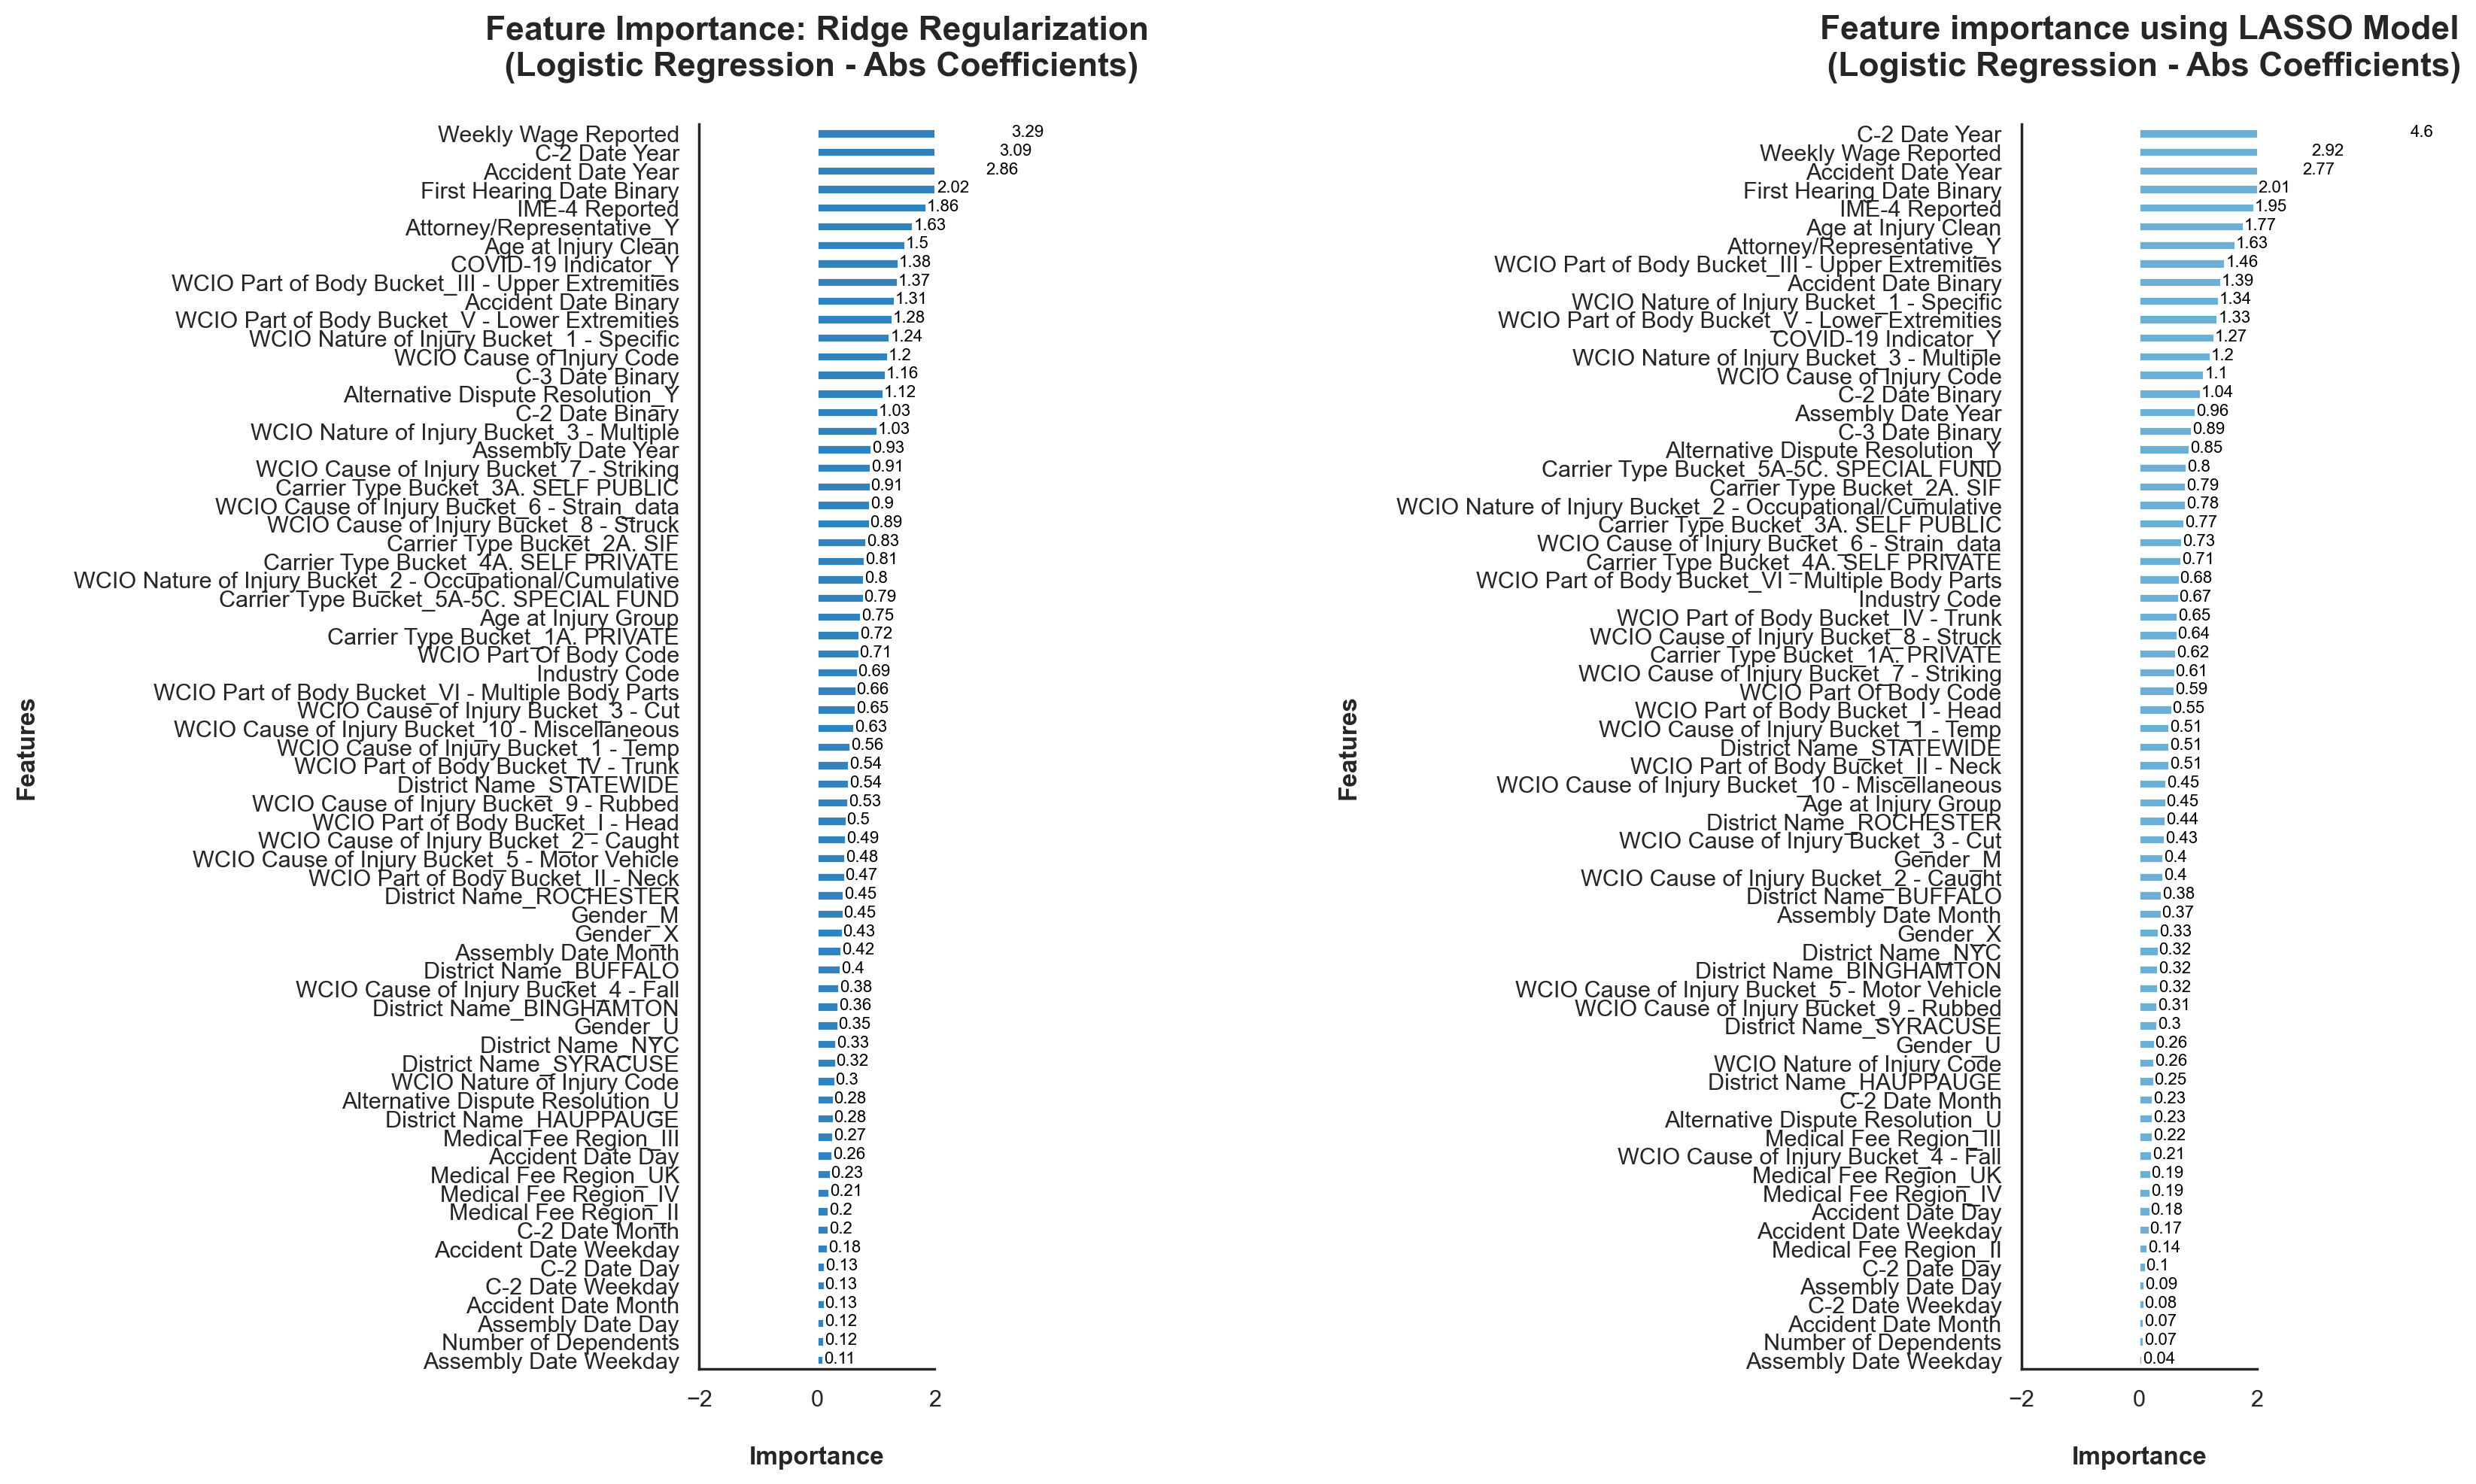

In [21]:
# Plot the importance of the features - Ridge Regularization & Lasso Regularization 
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plot the feature importance
ridge_import_coef.plot(kind='barh', color='#3182BD', ax=ax[0])
ax[0].set_title('Feature Importance: Ridge Regularization\n (Logistic Regression - Abs Coefficients)\n', fontsize=16, fontweight='bold')
ax[0].set_xlabel('\nImportance', fontsize=12, fontweight='bold')
ax[0].set_ylabel('Features\n', fontsize=12, fontweight='bold')
ax[0].set_xlim(-2, 2)

# Add the coefficients to the plot
for i in ax[0].patches:
    ax[0].text(i.get_width() + 0.01, i.get_y() + 0.1, str(round(i.get_width(), 2)), fontsize=8, color='black')

# Plot the importance of the features
lasso_imp_coef.plot(kind='barh', color='#6BAED6', ax=ax[1])
ax[1].set_xlim(-2, 2)
ax[1].set_title("Feature importance using LASSO Model\n (Logistic Regression - Abs Coefficients)\n", fontsize=16, fontweight='bold')
ax[1].set_xlabel('\nImportance', fontsize=12, fontweight='bold')
ax[1].set_ylabel('Features\n', fontsize=12, fontweight='bold')

# Add the coefficients to the plot
for i in ax[1].patches:
    ax[1].text(i.get_width() + 0.01, i.get_y() + 0.1, str(round(i.get_width(), 2)), fontsize=8, color='black')

sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()